In [78]:
import numpy as np
import pandas as pd
from scipy.fft import fft, ifft
import cmath

%matplotlib widget
import matplotlib.pyplot as plt

In [79]:
time_gating = True # указать, нужен или не нужен

### Импорт сырых данных из .s2p файла и перевод их в комплексные числа

In [80]:
# data_object_off_no_power = pd.read_csv('C:\\Users\\isvoropaev\\Desktop\\python_codes\\post_processing_RIS\\27sept\\TE\\struct_0deg_no_power.s1p', 
#                 sep=' ', header=None, skiprows=5, skipinitialspace=True, index_col=False,
#                 names=['Frequency','ReS22', 'ImS22'])

# data_object_off_2V = pd.read_csv('C:\\Users\\isvoropaev\\Desktop\\python_codes\\post_processing_RIS\\27sept\\TE\\struct_0deg_inverse2V.s1p', 
#                 sep=' ', header=None, skiprows=5, skipinitialspace=True, index_col=False,
#                 names=['Frequency','ReS22', 'ImS22'])

data_object_off_5V = pd.read_csv('C:\\Users\\isvoropaev\\Desktop\\python_codes\\post_processing_RIS\\29sept\\TE\\struct_0deg_inverse5V.s1p', 
                sep=' ', header=None, skiprows=5, skipinitialspace=True, index_col=False,
                names=['Frequency', 'ReS22', 'ImS22'])

data_object_on = pd.read_csv('C:\\Users\\isvoropaev\\Desktop\\python_codes\\post_processing_RIS\\29sept\\TE\\struct_0deg_6A.s1p', 
                sep=' ', header=None, skiprows=5, skipinitialspace=True, index_col=False,
                names=['Frequency', 'ReS22', 'ImS22'])

data_screen = pd.read_csv('C:\\Users\\isvoropaev\\Desktop\\python_codes\\post_processing_RIS\\29sept\\TE\\screen_0deg.s1p', 
                sep=' ', header=None, skiprows=5, skipinitialspace=True, index_col=False,
                names=['Frequency', 'ReS22', 'ImS22'])

data_free = pd.read_csv('C:\\Users\\isvoropaev\\Desktop\\python_codes\\post_processing_RIS\\29sept\\TE\\free_0deg.s1p', 
                sep=' ', header=None, skiprows=5, skipinitialspace=True, index_col=False,
                names=['Frequency', 'ReS22', 'ImS22'])

# data_fail = pd.read_csv('C:\\Users\\isvoropaev\\Desktop\\python_codes\\post_processing_RIS\\27sept\\fail\\stct_0deg_inverse5V.s1p', 
#                 sep=' ', header=None, skiprows=5, skipinitialspace=True, index_col=False,
#                 names=['Frequency', 'ReS22', 'ImS22'])

In [81]:
data_object_off_5V.head() # Смотрим корректность импорта данных

,Frequency,ReS22,ImS22
0,2.000000e+10,0.023232,-0.157343
1,2.000200e+10,-0.000318,-0.155778
2,2.000400e+10,-0.023939,-0.149975
3,2.000600e+10,-0.045762,-0.139689
4,2.000800e+10,-0.065180,-0.125512


Перевод данных в вид комплексных чисел

In [82]:
for dataset in [data_object_off_5V, data_object_on, data_screen, data_free]: 
    # это массив из указателей на соответствующие датафреймы
    dataset['s22']=dataset['ReS22']+1j*dataset['ImS22']

Удаление исходных колонок

In [83]:
# data_object_off_no_power = data_object_off_no_power.drop(['ReS22', 'ImS22'], axis=1)
# data_object_off_2V = data_object_off_2V.drop(['ReS22', 'ImS22'], axis=1)
data_object_off_5V = data_object_off_5V.drop(['ReS22', 'ImS22'], axis=1)
data_object_on = data_object_on.drop(['ReS22', 'ImS22'], axis=1)
data_screen = data_screen.drop(['ReS22', 'ImS22'], axis=1)
data_free = data_free.drop(['ReS22', 'ImS22'], axis=1)
# data_fail = data_fail.drop(['ReS22', 'ImS22'], axis=1)

In [84]:
data_object_off_5V.head() # просмотр нового датасета

,Frequency,s22
0,2.000000e+10,0.023232-0.157343j
1,2.000200e+10,-0.000318-0.155778j
2,2.000400e+10,-0.023939-0.149975j
3,2.000600e+10,-0.045762-0.139689j
4,2.000800e+10,-0.065180-0.125512j


Создаем переменные, с которыми будем непосредственно работать (массивы формата `pd.Series`)

In [85]:
frequency = data_object_on['Frequency']

# s11_object_off_no_power = data_object_off_no_power['s22']
# s11_object_off_2V = data_object_off_2V['s22']
s11_object_off_5V = data_object_off_5V['s22']

s11_object_on = data_object_on['s22']

s11_screen = data_screen['s22']

s11_free = data_free['s22']

# s11_fail = data_fail['s22']

### Предпросмотр графиков необработанных файлов

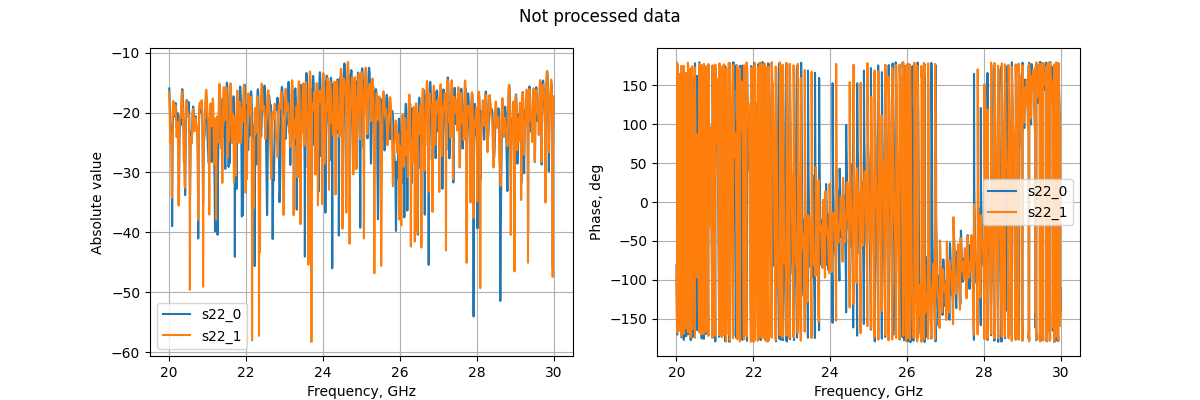

In [86]:
s_par = ['s22'] # Вести сюда названия S-параметров, которые нужны на графике в формате 'sij'
data = [data_object_off_5V, data_object_on] # Ввести сюда какие измерения нужны


'''Дальше  не трогать!!!'''
fig = plt.figure(figsize=(12,4))

ax_1 = fig.add_subplot(121)
ax_2 = fig.add_subplot(122)
for i, dataset in enumerate(data):
    for elem in s_par:
        ax_1.plot(dataset['Frequency']*1e-9, 20*np.log10(dataset[elem].apply(abs).to_numpy()), label=elem+'_'+str(i))
        ax_2.plot(dataset['Frequency']*1e-9, np.degrees(dataset[elem].apply(cmath.phase)), label=elem+'_'+str(i))

ax_1.set_xlabel("Frequency, GHz")
ax_1.set_ylabel("Absolute value")
ax_1.legend()
ax_1.grid()

ax_2.set_xlabel("Frequency, GHz")
ax_2.set_ylabel("Phase, deg")
ax_2.legend()
ax_2.grid()


fig.suptitle('Not processed data')
#plt.tight_layout()
plt.show()

### Time-Gating

In [87]:
N_fft = 2 ** 22 # количиство точек во временной области
# Должно иметь степень двойки для большей скорости и быть большем, чем количество частотных точек
T_max = 1 / (frequency[1]-frequency[0]) # продолжительность измеряемого импульса, определяется из количества измеряемых частотных точек
print(T_max)

5e-07


In [88]:
time = T_max*np.linspace(0, 1 + T_max, N_fft) # набор точек во временной области
time[-1] # последний элемент

5.0000025e-07

Просмотр S-параметров во временной области

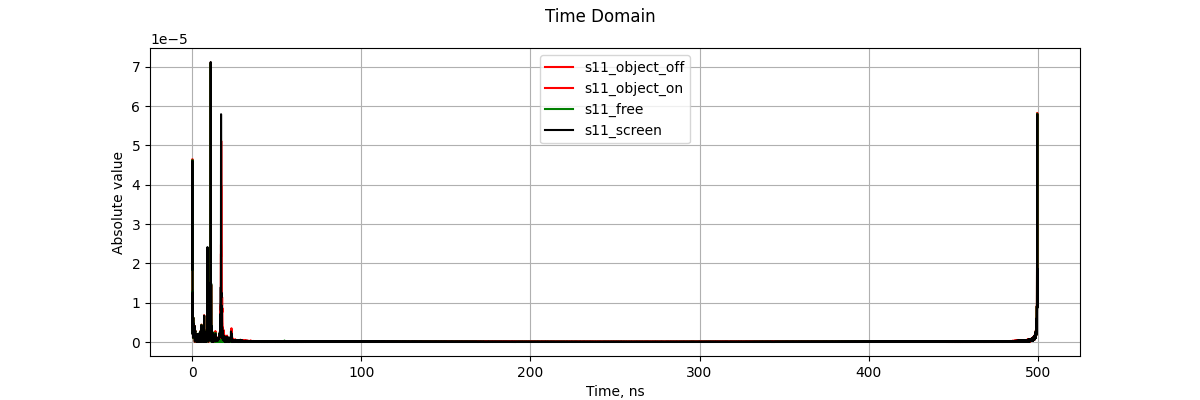

In [89]:
fig2 = plt.figure(figsize=(12,4))

ax_1 = fig2.add_subplot(111)
ax_1.plot(time*1e9, abs(ifft(s11_object_off_5V.to_numpy(), n=N_fft)),'r', label='s11_object_off')
ax_1.plot(time*1e9, abs(ifft(s11_object_on.to_numpy(), n=N_fft)),'r', label='s11_object_on')
ax_1.plot(time*1e9, abs(ifft(s11_free.to_numpy(), n=N_fft)),'g', label='s11_free')
ax_1.plot(time*1e9, abs(ifft(s11_screen.to_numpy(), n=N_fft)),'k', label='s11_screen')

ax_1.set_xlabel("Time, ns")
ax_1.set_ylabel("Absolute value")
ax_1.legend()
ax_1.grid()


fig2.suptitle('Time Domain')
plt.show()

In [90]:
gate_s11 = np.array([[0, 15], [20, 900]])*1e-9 # заполнить промежутками времени, которые необходимо вырезать в нс

In [91]:
def time_gate_s_param(gate: np.ndarray, s_par: pd.core.series.Series, n=N_fft, time=time):
    s = s_par.to_numpy()
    time_dom_s = pd.Series(ifft(s, n=n))
    for k in range(gate.shape[0]):
        if len(gate[k, :]) != 0:
            numbers = (time >= gate[k, 0]) & (time <= gate[k, 1])
            time_dom_s.loc[numbers] = 0
            #print(time_dom_s.head())
    s_new = fft(time_dom_s.to_numpy())
    s_new = s_new[0:len(frequency)]
    return pd.Series(s_new)

Проведение тайм-гейтинга

In [92]:
if time_gating == True:
    # s11_object_off_no_power = time_gate_s_param(gate=gate_s11, s_par=s11_object_off_no_power)
    # s11_object_off_2V = time_gate_s_param(gate=gate_s11, s_par=s11_object_off_2V)
    s11_object_off_5V = time_gate_s_param(gate=gate_s11, s_par=s11_object_off_5V)
    s11_object_on = time_gate_s_param(gate=gate_s11, s_par=s11_object_on)
    s11_screen = time_gate_s_param(gate=gate_s11, s_par=s11_screen)
    s11_free = time_gate_s_param(gate=gate_s11, s_par=s11_free)
    #s11_fail = time_gate_s_param(gate=gate_s11, s_par=s11_fail)

In [93]:
s11_object_on.shape # проверка, что число точек осталось таким же, как в исходных данных

(5001,)

Просмотр S-параметров после тайм-гейтинга

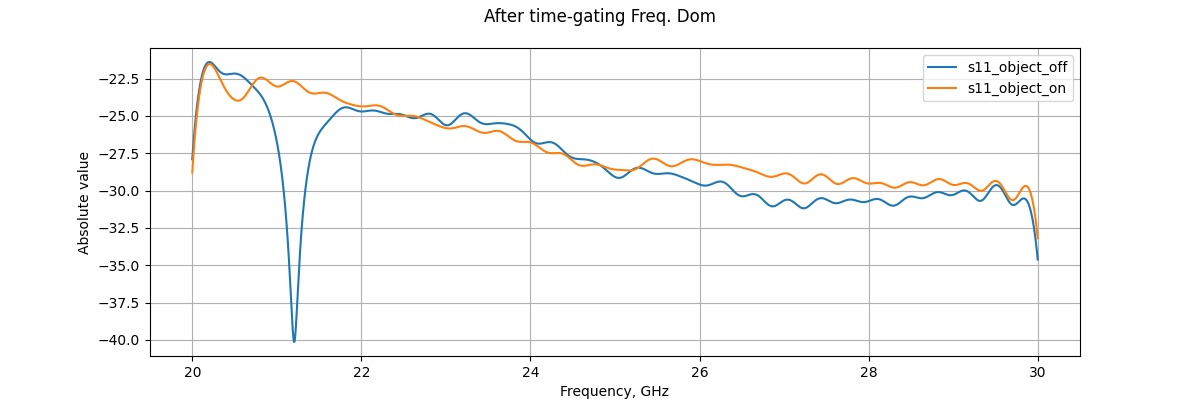

In [94]:
param = [s11_object_off_5V, s11_object_on]
name = ['s11_object_off', 's11_object_on']

fig3 = plt.figure(figsize=(12,4))

ax_1 = fig3.add_subplot(111)

for i, s_par in enumerate(param):
    ax_1.plot(frequency*1e-9, 20*np.log10(s_par.apply(abs).to_numpy()), label=name[i])
ax_1.set_xlabel("Frequency, GHz")
ax_1.set_ylabel("Absolute value")
ax_1.legend()
ax_1.grid()


fig3.suptitle('After time-gating Freq. Dom')
plt.show()

### Итоговые выражения для коэффициента отражения

In [95]:
# Gamma_off_no_power = -(s11_object_off_no_power - s11_free) / (s11_screen - s11_free)
# Gamma_off_2V = -(s11_object_off_2V - s11_free) / (s11_screen - s11_free)
Gamma_off_5V = -(s11_object_off_5V - s11_free) / (s11_screen - s11_free)
Gamma_on = -(s11_object_on - s11_free) / (s11_screen - s11_free)

### Импорт графиков из CST

In [96]:
reflecting_coef_off = pd.read_csv('C:\\Users\\isvoropaev\\Desktop\\python_codes\\post_processing_RIS\\off_cst\\0deg.txt',
                                  sep='\t', header=None, skiprows=3, index_col=False, names=['Frequency', 'ReSz11', 'ImSz11'])
reflecting_coef_on = pd.read_csv('C:\\Users\\isvoropaev\\Desktop\\python_codes\\post_processing_RIS\\on_cst\\0deg.txt',
                                  sep='\t', header=None, skiprows=3, index_col=False, names=['Frequency', 'ReSz11', 'ImSz11'])

In [97]:
reflecting_coef_off['Sz11'] = reflecting_coef_off['ReSz11'] + 1j*reflecting_coef_off['ImSz11']
reflecting_coef_on['Sz11'] = reflecting_coef_on['ReSz11'] + 1j*reflecting_coef_on['ImSz11']

In [98]:
reflecting_coef_off = reflecting_coef_off.drop(['ReSz11', 'ImSz11'], axis=1)
reflecting_coef_on = reflecting_coef_on.drop(['ReSz11', 'ImSz11'], axis=1)

### Сравенние графиков с результатами CST

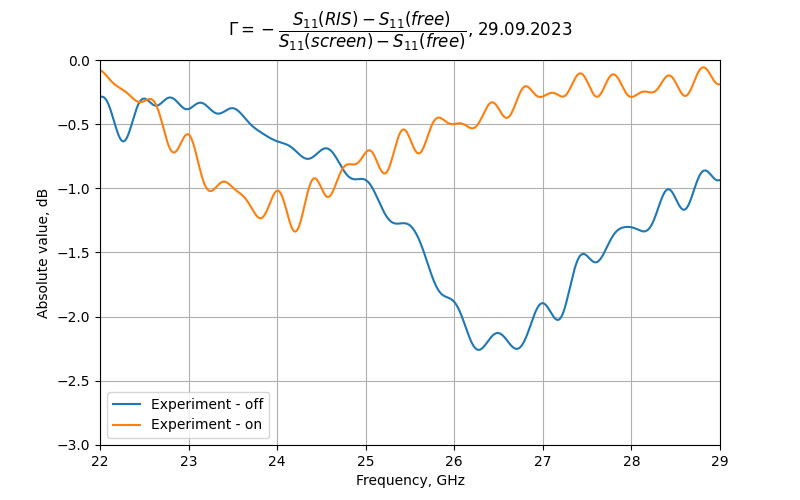

In [99]:
fig4 = plt.figure(figsize=(8, 5))

ax_1 = fig4.add_subplot(111)

ax_1.plot(frequency*1e-9, 20*np.log10(Gamma_off_5V.apply(abs).to_numpy()), label='Experiment - off')
ax_1.plot(frequency*1e-9, 20*np.log10(Gamma_on.apply(abs).to_numpy()), label='Experiment - on')

# ax_1.plot(frequency*1e-9, 20*np.log10(Gamma_off.apply(abs).to_numpy()), label='No Voltage')
# ax_1.plot(frequency*1e-9, 20*np.log10(Gamma_on.apply(abs).to_numpy()), label='Inverse voltage')

# ax_1.plot(cst_freq, 20*np.log10(cst_Gamma_off.apply(abs).to_numpy()), label='CST Modeling - off')
# ax_1.plot(cst_freq, 20*np.log10(cst_Gamma_on.apply(abs).to_numpy()), label='CST Modeling - on')
ax_1.set_xlabel("Frequency, GHz")
ax_1.set_ylabel("Absolute value, dB")
ax_1.set_xlim(left=22, right=29)
ax_1.set_ylim(bottom=-3, top=0)
ax_1.legend()
ax_1.grid()


fig4.suptitle(r'$\Gamma = -\dfrac{S_{11}(RIS)-S_{11}(free)}{S_{11}(screen)-S_{11}(free)}$, 29.09.2023')
plt.show()

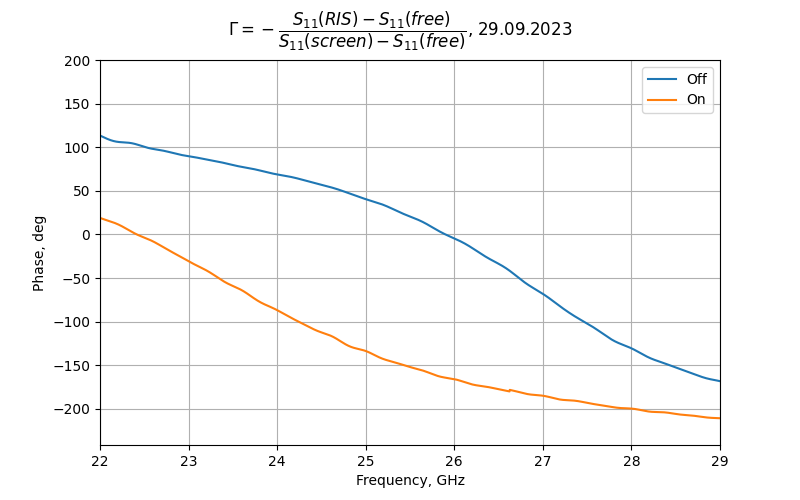

In [100]:
fig6 = plt.figure(figsize=(8, 5))

ax_1 = fig6.add_subplot(111)

ax_1.plot(frequency*1e-9, np.degrees(pd.Series(Gamma_off_5V).apply(cmath.phase).to_numpy()), label='Off')
ax_1.plot(frequency*1e-9, np.unwrap(np.degrees(pd.Series(Gamma_on).apply(cmath.phase).to_numpy())), label='On')

ax_1.set_xlabel("Frequency, GHz")
ax_1.set_ylabel("Phase, deg")
ax_1.set_xlim(left=22, right=29)
ax_1.legend()
ax_1.grid()


fig6.suptitle(r'$\Gamma = -\dfrac{S_{11}(RIS)-S_{11}(free)}{S_{11}(screen)-S_{11}(free)}$, 29.09.2023')
plt.show()

In [101]:
def m_unwrap(x):
    if x >= 0:
        return x
    else:
        return 360 + x

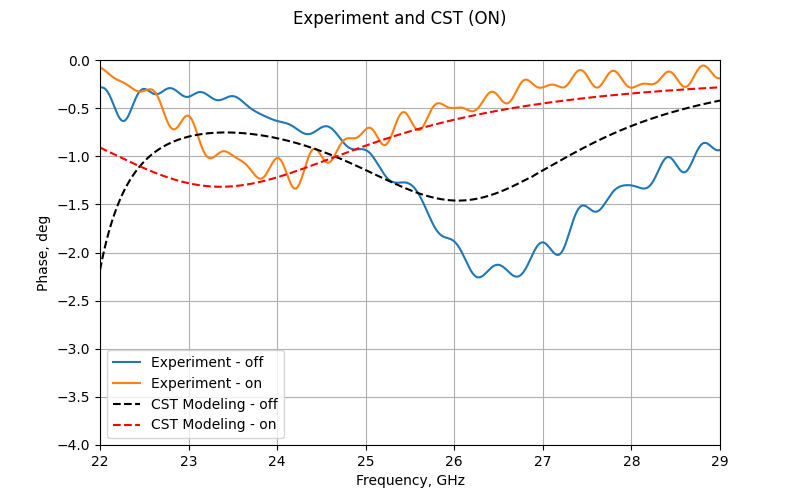

In [108]:
fig7 = plt.figure(figsize=(8,5))

ax_1 = fig7.add_subplot(111)

ax_1.plot(frequency*1e-9, 20*np.log10(Gamma_off_5V.apply(abs).to_numpy()), label='Experiment - off')
ax_1.plot(frequency*1e-9, 20*np.log10(Gamma_on.apply(abs).to_numpy()), label='Experiment - on')
ax_1.plot(reflecting_coef_off['Frequency'], 20*np.log10(reflecting_coef_off['Sz11'].apply(abs).to_numpy()), linestyle='--', color='k', label='CST Modeling - off')
ax_1.plot(reflecting_coef_on['Frequency'], 20*np.log10(reflecting_coef_on['Sz11'].apply(abs).to_numpy()), linestyle='--', color='r', label='CST Modeling - on')

ax_1.set_xlabel("Frequency, GHz")
ax_1.set_ylabel("Phase, deg")
ax_1.set_xlim(left=22, right=29)
ax_1.set_ylim(top=0, bottom=-4)
ax_1.legend()
ax_1.grid()


fig7.suptitle('Experiment and CST (ON)')
plt.show()

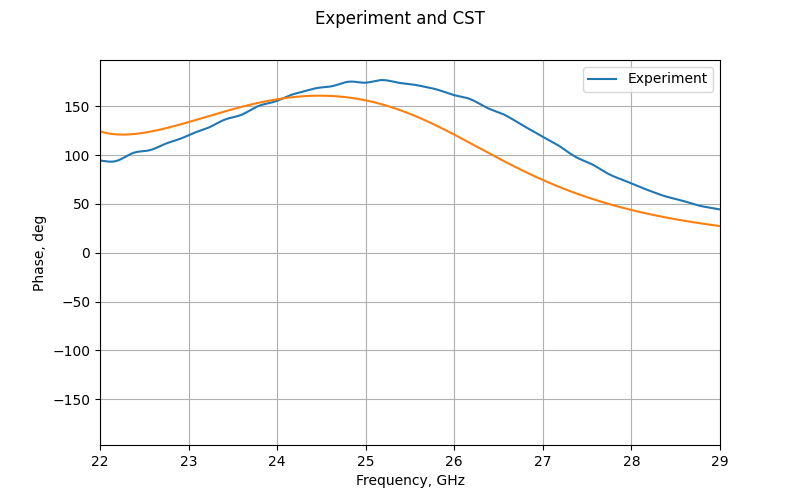

In [113]:
fig5 = plt.figure(figsize=(8,5))

ax_1 = fig5.add_subplot(111)

ax_1.plot(frequency*1e-9, np.degrees(pd.Series(Gamma_off_5V / Gamma_on).apply(cmath.phase).to_numpy()), label='Experiment')
ax_1.plot(reflecting_coef_off['Frequency'], np.degrees(pd.Series(reflecting_coef_off['Sz11'] / reflecting_coef_on['Sz11']).apply(cmath.phase).to_numpy()))

ax_1.set_xlabel("Frequency, GHz")
ax_1.set_ylabel("Phase, deg")
ax_1.set_xlim(left=22, right=29)
#ax_1.set_ylim(top=190, bottom=140)
ax_1.legend()
ax_1.grid()


fig5.suptitle('Experiment and CST')
plt.show()

In [ ]:
delta_phi = pd.DataFrame({'Frequency':frequency, 'G_off/G_on': Gamma_off_5V/Gamma_on})

In [ ]:
#delta_phi.to_csv('C:\\Users\\isvoropaev\\Desktop\\python_codes\\post_processing_RIS\\phase_diff\\0deg_29sept.csv' ,index=False)